In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

2023-02-13 09:16:06.395370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 09:16:06.542662: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 09:16:07.410177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [6]:
client.cluster

PBSCluster(23ccdc66, 'tcp://10.12.206.36:43107', workers=30, threads=30, memory=698.40 GiB)

In [7]:
def normalize(var):
    return (var-min(var))/(max(var)-min(var))

def unnormalize(norm_var,raw_var):
    return norm_var*np.array(max(raw_var)-min(raw_var)) + np.array(min(raw_var))

In [12]:
def get_ix(ds,pft):
    ix=ds.pfts1d_itype_veg==pft
    a=ds.pfts1d_lat[ix]
    o=ds.pfts1d_lon[ix]
    
    nlon=len(ds.lon)
    nlat=len(ds.lat)
    nx=len(a)

    lats=xr.DataArray(np.tile(ds.lat.values.reshape([-1,1,1]),[1,nlon,nx]),dims=['lat','lon','pft'])
    lons=xr.DataArray(np.tile(ds.lon.values.reshape([1,-1,1]),[nlat,1,nx]),dims=['lat','lon','pft'])
    ix=((abs(lats-a)<0.25)&(abs(lons-o)<0.25)).sum(dim='pft')
    
    return ix==1
def pftgrid(da,ds):

    #set up dims for outgoing data array
    dims=[]
    s=[]
    ix=get_ix(ds,1)
    for dim in da.dims:
        if dim !='pft':
            dims.append(dim)
            s.append(len(da[dim]))
    dims=[*dims,*ix.dims]
    s=[*s,*ix.shape]
    ndims=len(dims)

    das=[]
    ix0=[slice(None) for i in range(ndims-2)]

    pfts=np.unique(ds.pfts1d_itype_veg)
    for pft in pfts:
        out=np.zeros(s)+np.nan
        if pft>0:
            ix=get_ix(ds,pft)
            ix2=tuple([*ix0,ix])
            ixp=ds.pfts1d_itype_veg==pft
            out[ix2]=da.isel(pft=ixp)
        das.append(xr.DataArray(out.copy(),dims=dims))

    da_out=xr.concat(das,dim='pft')
    da_out['pft']=pfts
    da_out['lat']=ds.lat
    da_out['lon']=ds.lon
    for dim in da.dims:
        if dim !='pft':
            da_out[dim]=da[dim]

    return da_out

### Load PPE LAI metrics

In [5]:
#read in LAI metrics
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')

In [8]:
default = ds.sel(ens=0)
def_pft_LAI = default.TLAI_pft_avg_2003

In [9]:
pft_LAI = ds.TLAI_pft_avg_2003

In [10]:
# get parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [11]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][:17]

### Load SP on pft's

In [12]:
# load SP on pfts (full grid)
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

In [13]:
#calculate SP LAI, by pft
lai=amean(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

### train emulators

In [14]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_matern32

2023-02-13 09:21:39.635072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-13 09:21:39.644765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc35): /proc/driver/nvidia/version does not exist
2023-02-13 09:21:39.698751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


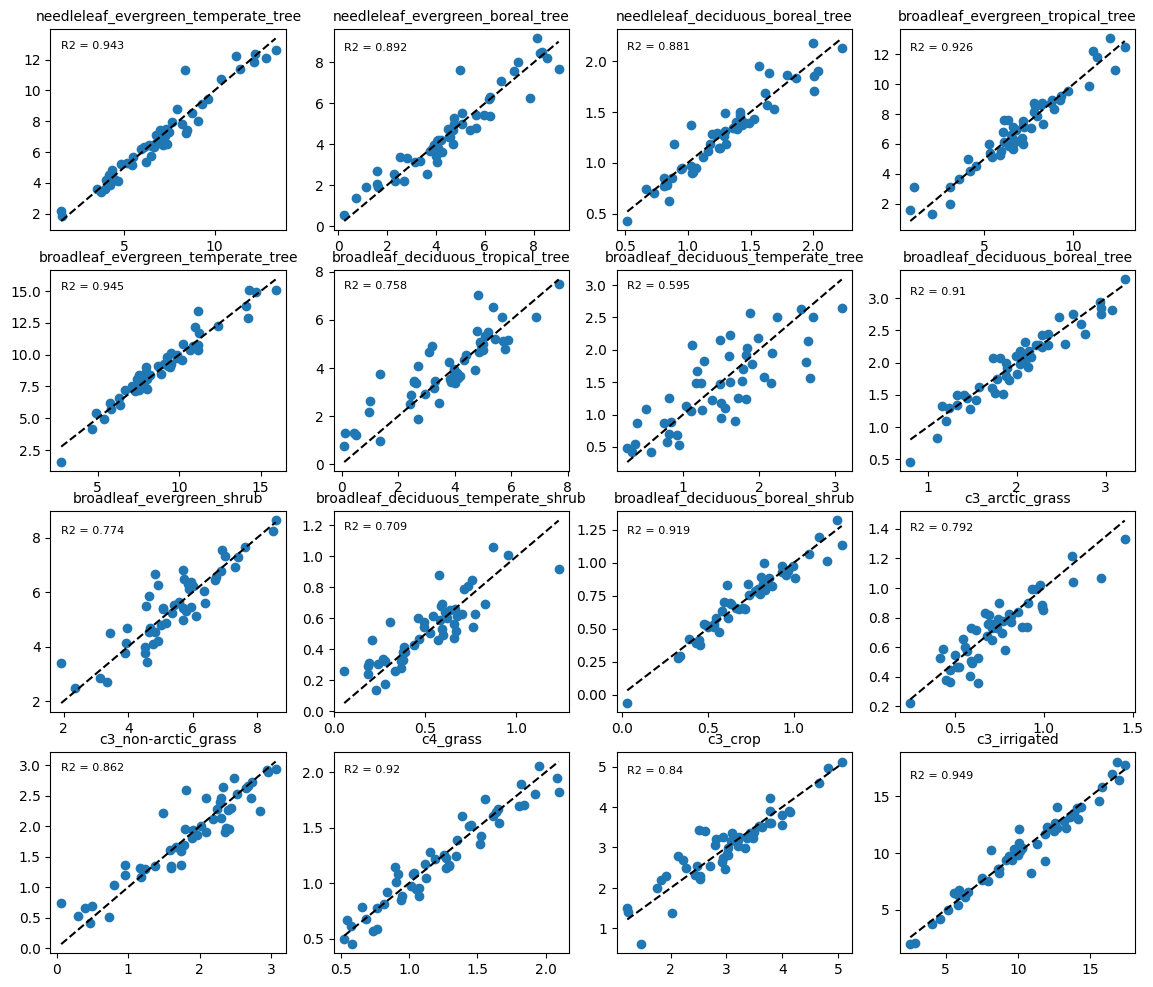

In [15]:
# Train individual emulators for each PFT
plt.figure(figsize=[14,12])
plt.rcParams.update({'font.size': 10})

emulator_dict = {}
keys = range(1,17)

for pft in range(1,17):
    
    var_raw = pft_LAI.isel(pft=pft).compute()
    var = normalize(var_raw)

    n_test = 50 # number of ensemble members to test emulator
    Y = var[1:].values # target variable excluding default model [0]

    X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
    y_test, y_train = Y[:n_test], Y[n_test:]

    emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
    emulator.train()

    emulator_dict[keys[pft-1]] = emulator
    
    #plot emulator validation
    y_pred, y_pred_var = emulator.predict(X_test.values)
    rms = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test,y_pred)
    
    y_test_raw = unnormalize(y_test,var_raw)

    ax = plt.subplot(4,4,pft)
    ax.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
    ax.scatter(y_test_raw,unnormalize(y_pred,var_raw))
    ax.text(min(y_test_raw),max(y_test_raw)*0.95,'R2 = '+str(np.round(r2,3)),fontsize=8)
    ax.set_title(pfts[pft],fontsize = 10)

#plt.savefig('../figs/param_sens/PFT_emulator_eval_GM-AM-LAI.png',dpi=200)

In [16]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

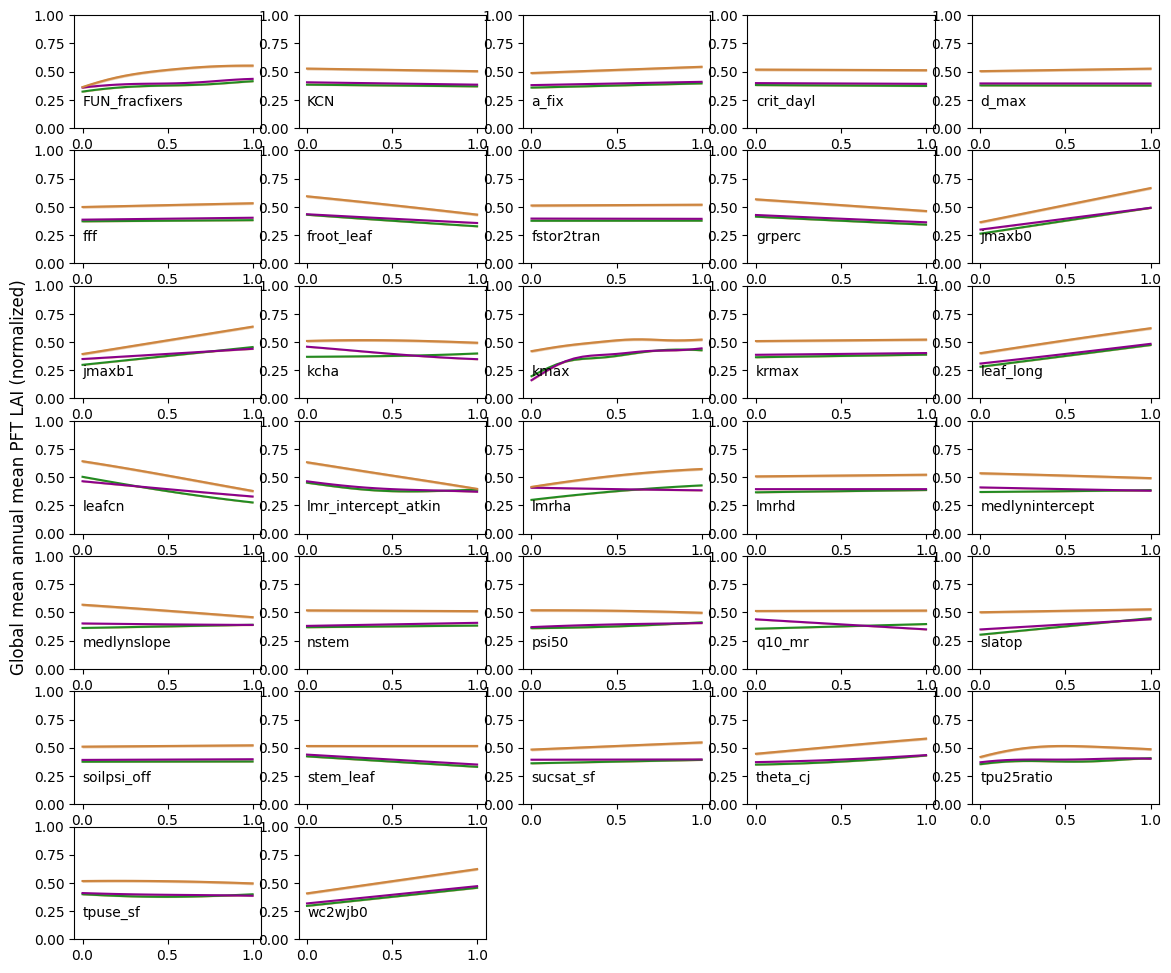

In [17]:
plt.figure(figsize=[14,12])

sample = unif
for i, p in enumerate(ppe_params.columns):
    
    ax=plt.subplot(7,5,i+1)
    sample[p] = s
    oaat, sd = emulator_dict[1].predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='forestgreen',label='NL')
    
    sample[p] = s
    oaat, sd = emulator_dict[4].predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='darkmagenta',label='BL')
    
    sample[p] = s
    oaat, sd = emulator_dict[13].predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='peru',label='C3')
    
    
    plt.text(0,0.2,p)
    #plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0,1])
    if i == 15:
        plt.ylabel('Global mean annual mean PFT LAI (normalized)',fontsize=12)
    
#plt.savefig('../figs/param_sens/OAAT_sensitivity_PFT1-4-13_gmLAI.png',dpi=200)

### Fourier amplitude sensitivity

In [18]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

In [19]:
for pft in range(1,17):
    Y, _ = emulator_dict[pft].predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
    if pft ==1:
        FAST_sens = pd.DataFrame.from_dict(FAST['S1'])
    else:
        FAST_sens[pft] = FAST['S1']
        
FAST_sens.index = pd.DataFrame.from_dict(FAST).names
FAST_sens.columns = pfts[1:17]

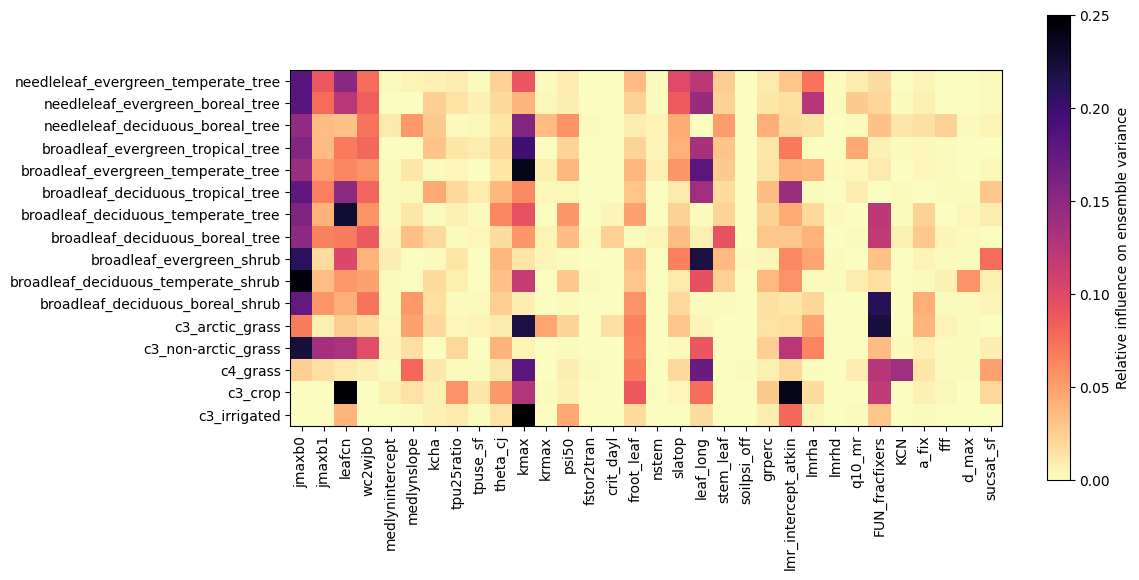

In [20]:
# heatmap of all global mean variables
params = ['jmaxb0', 'jmaxb1', 'leafcn', 'wc2wjb0', 'medlynintercept', 'medlynslope', 'kcha', 'tpu25ratio', 'tpuse_sf', 'theta_cj',
          'kmax', 'krmax', 'psi50', 'fstor2tran','crit_dayl', 'froot_leaf', 'nstem', 'slatop','leaf_long', 'stem_leaf', 'soilpsi_off',
          'grperc', 'lmr_intercept_atkin', 'lmrha', 'lmrhd', 'q10_mr', 'FUN_fracfixers', 'KCN', 'a_fix', 'fff', 'd_max', 'sucsat_sf']

FAST_sens = FAST_sens.reindex(params)

var_names = FAST_sens.columns
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
im = ax.imshow(FAST_sens.transpose(),cmap='magma_r',vmin=0,vmax=0.25)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative influence on ensemble variance")
plt.tight_layout()
#plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM-LAI-PFT_heatmap.png',dpi=200)